In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
train_path = '../dataset/train/'
test_path = '../dataset/test/'

labels = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

In [3]:
def count_expression(path, dict):
    for expression in os.listdir(path): 
        dict[expression] = len(os.listdir(path + expression))

In [4]:
train_expressions_counts = {}
test_expressions_counts = {}

count_expression(train_path, train_expressions_counts)
count_expression(test_path, test_expressions_counts)

print(train_expressions_counts)
print(test_expressions_counts)

{'neutral': 4965, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'surprise': 3171, 'sad': 4830, 'angry': 3995}
{'neutral': 1233, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'surprise': 831, 'sad': 1247, 'angry': 958}


In [5]:
def bar_plot(x, heights, color = 'blue', label = None, loc = None):
    plt.bar(x, heights, color = color, label = label)
    plt.legend(loc=loc)
    plt.show()

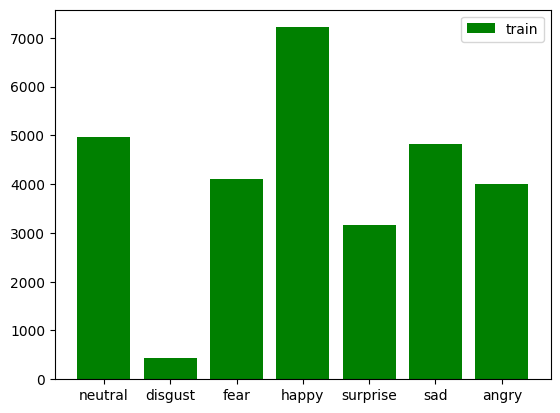

In [6]:
bar_plot(train_expressions_counts.keys(), train_expressions_counts.values(), color = 'green', label = 'train', loc = 'upper right')

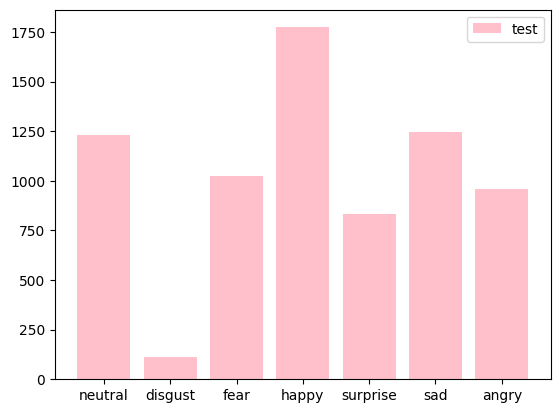

In [7]:
bar_plot(test_expressions_counts.keys(), test_expressions_counts.values(), color = 'pink', label = 'test', loc='upper right')

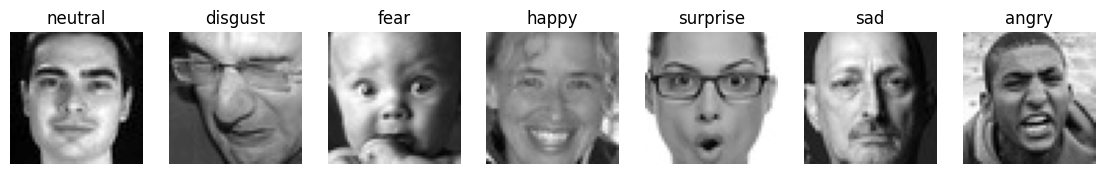

In [8]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_path):
    directory = train_path + expression
    image_index = random.randint(0, test_expressions_counts[expression])
    img = Image.open((directory + '/' + os.listdir(directory)[image_index]))
    plt.subplot(1,7,i)
    plt.imshow(img, cmap='gray')
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [9]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_str, label_idx in labels.items():
            label_dir = os.path.join(root_dir, label_str)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('L')

        if self.transform:
            img = self.transform(img)

        return img, label

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets and dataloaders
train_dataset = EmotionDataset(root_dir=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = EmotionDataset(root_dir=test_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 input channel, 32 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 input channels, 64 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 64 input channels, 128 output channels
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 6 * 6, 512)  # Update the size here after calculation
        self.fc2 = nn.Linear(512, 7)  # 7 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch_size, 32, 24, 24]
        x = self.pool(F.relu(self.conv2(x)))  # [batch_size, 64, 12, 12]
        x = self.pool(F.relu(self.conv3(x)))  # [batch_size, 128, 6, 6]
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, losses, num_epochs=15):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

losses = []
train(model, train_loader, criterion, optimizer, losses)

Epoch [1/15], Loss: 1.5697
Epoch [2/15], Loss: 1.2952
Epoch [3/15], Loss: 1.1469
Epoch [4/15], Loss: 1.0149
Epoch [5/15], Loss: 0.8645
Epoch [6/15], Loss: 0.6944
Epoch [7/15], Loss: 0.5066
Epoch [8/15], Loss: 0.3380
Epoch [9/15], Loss: 0.2088
Epoch [10/15], Loss: 0.1329
Epoch [11/15], Loss: 0.1089
Epoch [12/15], Loss: 0.0908
Epoch [13/15], Loss: 0.0788
Epoch [14/15], Loss: 0.0717
Epoch [15/15], Loss: 0.0765


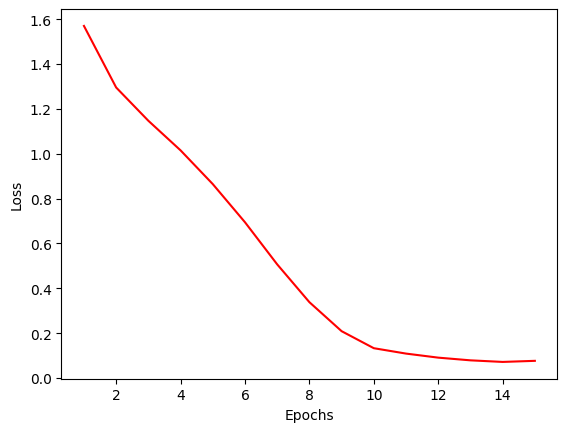

In [12]:
plt.plot(range(1, len(losses)+1), losses, 'r-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [13]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

print(f'Validation Accuracy: {evaluate(model, val_loader):.2f}%')
print(f'Train Accuracy: {evaluate(model, train_loader):.2f}%')

Validation Accuracy: 57.16%
Train Accuracy: 98.01%


In [14]:
model_scripted = torch.jit.script(model)
model_scripted.save('fer_model.pt')